# KAN PINO

Now trying to use a physics-informed loss only instead.

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
import pandas as pd
from IPython.display import display

In [3]:
N_SAMPLES = 32
EPOCHS = 500
LR = 1e-2
BS = 128

## Utility funcs

In [4]:
def plot_loss(ldf, columns=["train_loss", "valid_loss"], ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    for col in columns:
        ax.plot(ldf[col], label=col, lw=0.5)
    ax.legend()
    ax.set_yscale("log")

## Damped harmonic oscillator

This should be something nice and simple I can train on.

Copying bits and pieces from [here](https://github.com/benmoseley/DLSC-2023/blob/main/lecture-5/PINN%20demo.ipynb) _but_ importantly training it as a neural _operator_ and with KANs.

In [5]:
def f(d, w0, t):
    "Defines the analytical solution to the under-damped harmonic oscillator problem above."
    # assert d < w0
    w = np.sqrt(w0**2 - d**2)
    phi = np.arctan(-d / w)
    A = 1 / (2 * np.cos(phi))
    cos = np.cos(phi + w * t)
    exp = np.exp(-d * t)
    u = exp * 2 * A * cos
    return u


def get_rand_d():
    return np.random.rand() * 1 + 0.3


def get_rand_w0():
    return np.random.rand() * 10 * np.pi * 0.05 + 15


# setting m = 1
get_μ = lambda d: 2 * d
get_k = lambda w0: w0**2

In [6]:
def plot_solution(d, w0, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    t = np.linspace(0, 1, 1000)
    u = f(d, w0, t)
    ax.plot(t, u)
    ax.set_xlabel("t")
    ax.set_ylabel("u")
    ax.set_title(f"d={d:.2f}, w0={w0:.2f}")

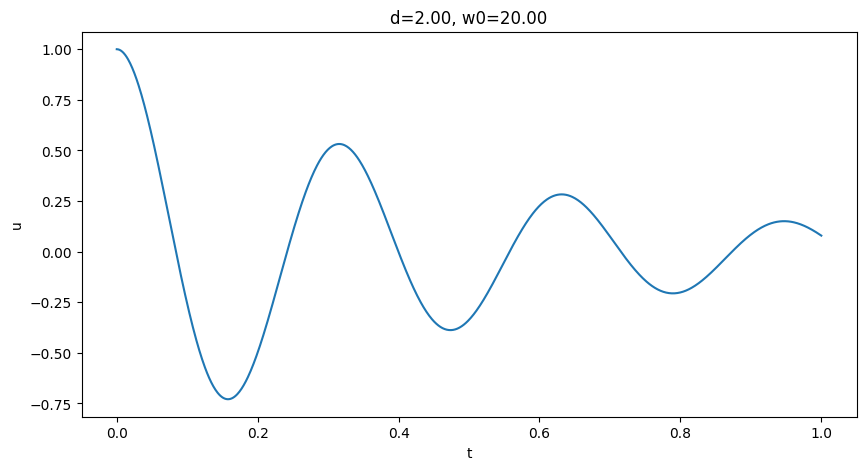

In [7]:
plot_solution(2, 20)

## KAN

Following some of the tips [here](https://github.com/KindXiaoming/pykan/tree/master?tab=readme-ov-file#advice-on-hyperparameter-tuning).

### Data

In [8]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader


class ONetData(Dataset):
    def __init__(self, N=1000, n_samples=N_SAMPLES, test=False):
        self.N = N
        self.n_samples = n_samples
        self.x_sensor = np.linspace(0, 1, self.n_samples)
        self.test = test

    def __len__(self):
        return self.N

    def __getitem__(self, _):
        d = get_rand_d()
        w0 = get_rand_w0()
        # d = 2
        # w0 = 20
        y = torch.tensor(np.random.rand(), dtype=torch.float32, requires_grad=True)[None]
        params = torch.tensor([d, w0], dtype=torch.float32)
        bc = torch.tensor(f(d, w0, 0.0), dtype=torch.float32)[None]
        return params, bc, y

In [9]:
train_dset = ONetData(N=1000)
valid_dset = ONetData(N=1000)

train_dl = DataLoader(train_dset, batch_size=BS, shuffle=True)
valid_dl = DataLoader(valid_dset, batch_size=BS, shuffle=False)

In [10]:
pb, bcb, yb = next(iter(train_dl))
pb.shape, bcb.shape, yb.shape

(torch.Size([128, 2]), torch.Size([128, 1]), torch.Size([128, 1]))

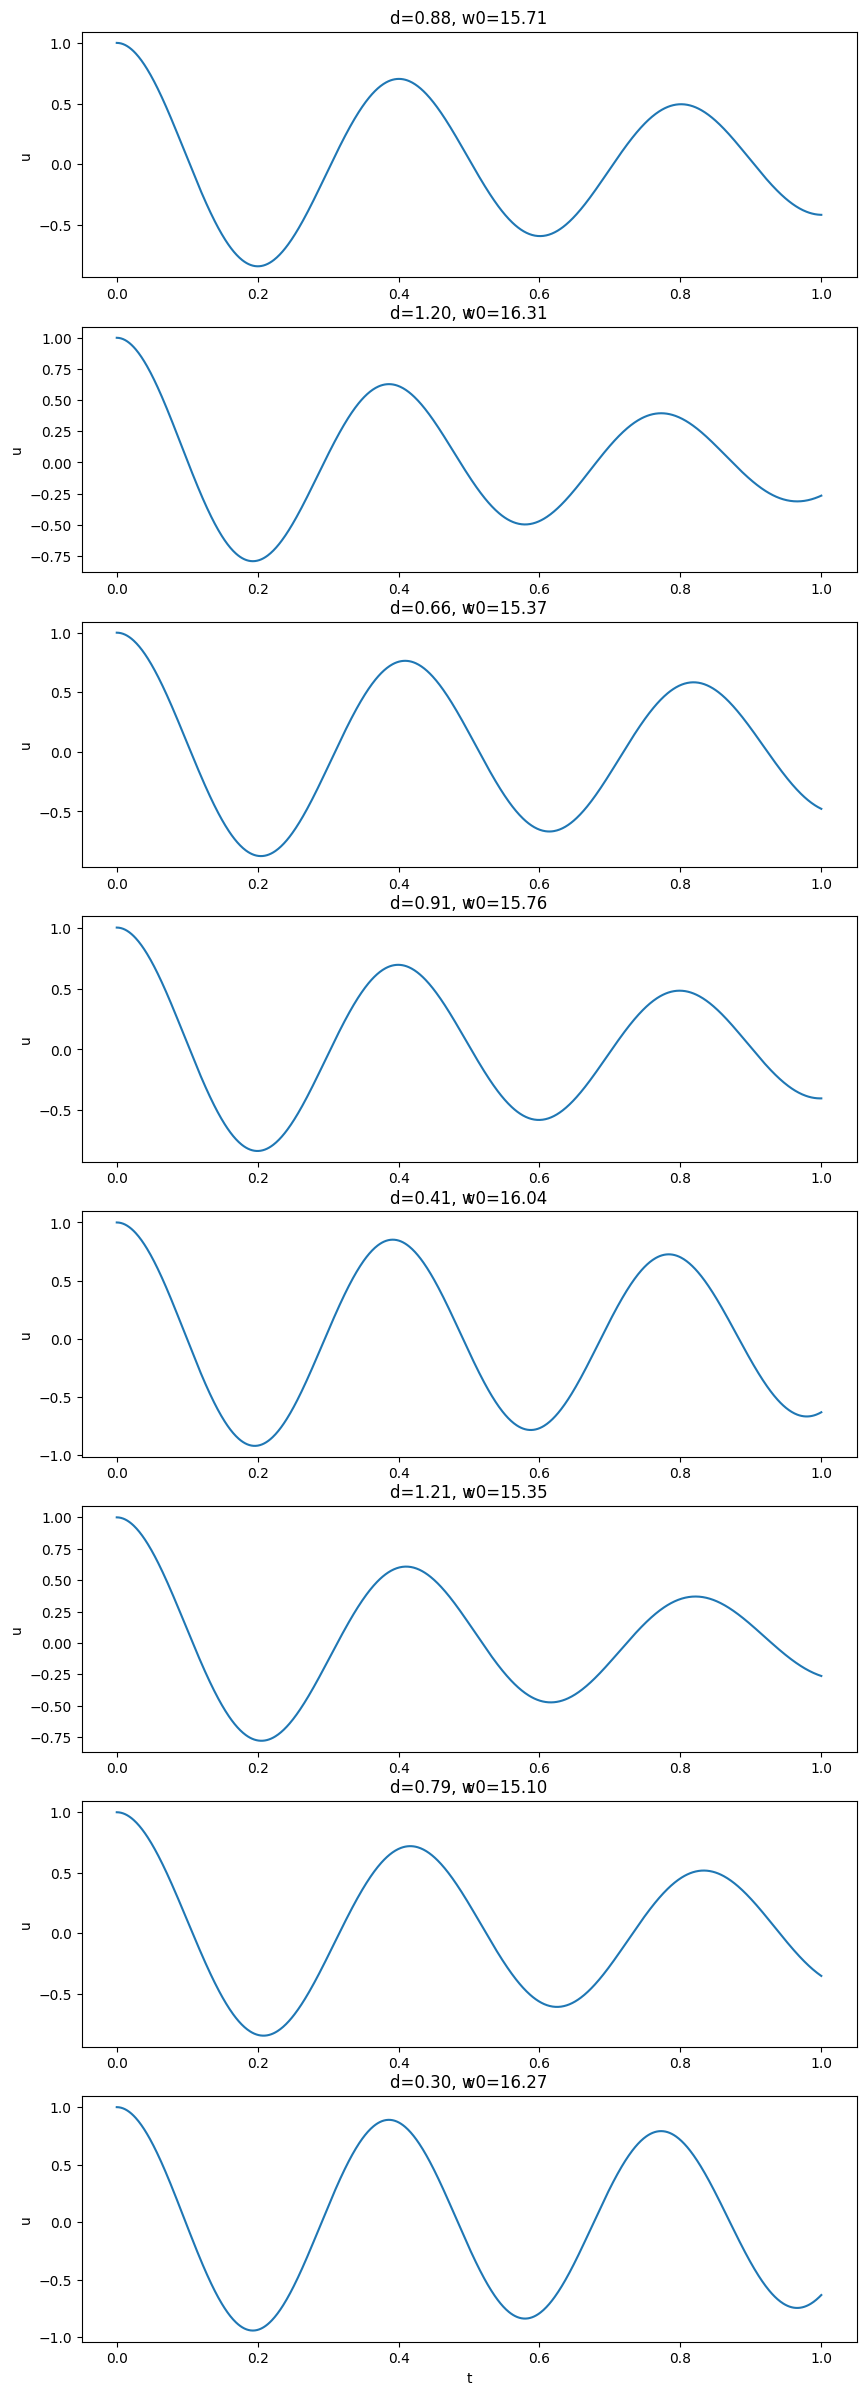

In [11]:
fig, axes = plt.subplots(8, 1, figsize=(10, 30))

for i in range(8):
    plot_solution(pb[i, 0].item(), pb[i, 1].item(), ax=axes[i])

### Model

In [12]:
from kan import KAN
from torch import nn

In [32]:
class KANONet(nn.Module):
    def __init__(self):
        super().__init__()
        self.solution_network = KAN(width=[4, 4, 1, 1], grid=10, k=4, seed=0, device="cpu")

    def forward(self, params, bc, y):
        x = torch.cat([params, bc, y], dim=1)
        return self.solution_network(x)

In [33]:
model = KANONet()

In [34]:
pb.shape, bcb.shape, yb.shape

(torch.Size([128, 2]), torch.Size([128, 1]), torch.Size([128, 1]))

In [35]:
pb, bcb, yb = next(iter(train_dl))

with torch.no_grad():
    out = model(pb, bcb, yb)

out.shape

torch.Size([128, 1])

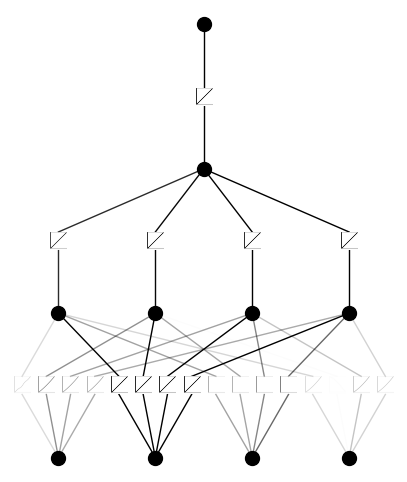

In [36]:
model.solution_network.plot()

## Training

In [37]:
from torch.optim.lr_scheduler import OneCycleLR

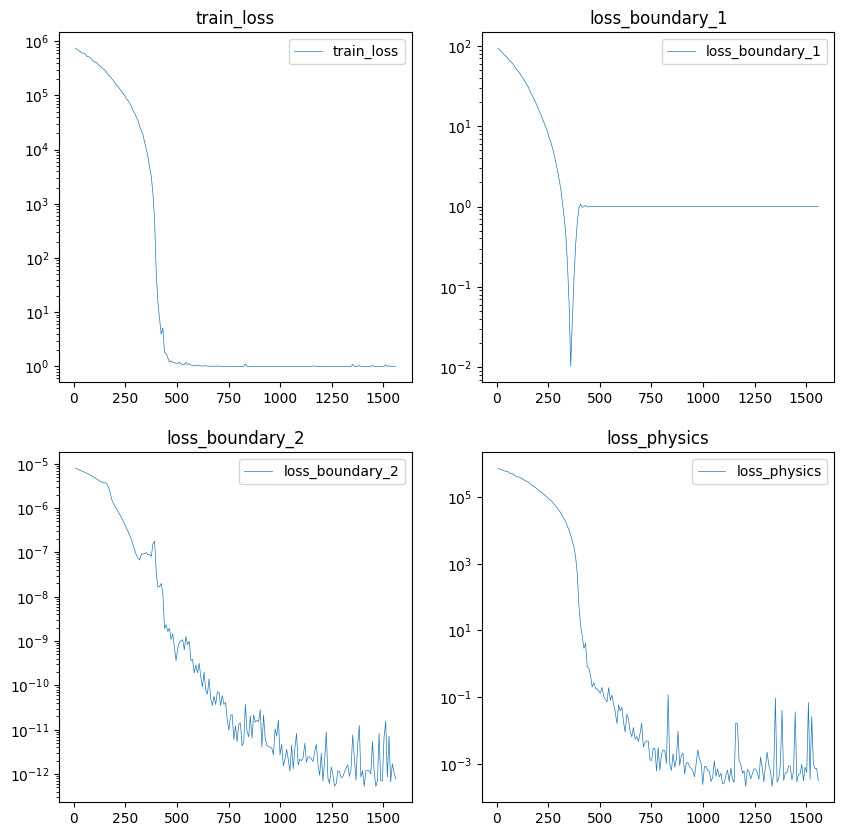

KeyboardInterrupt: 

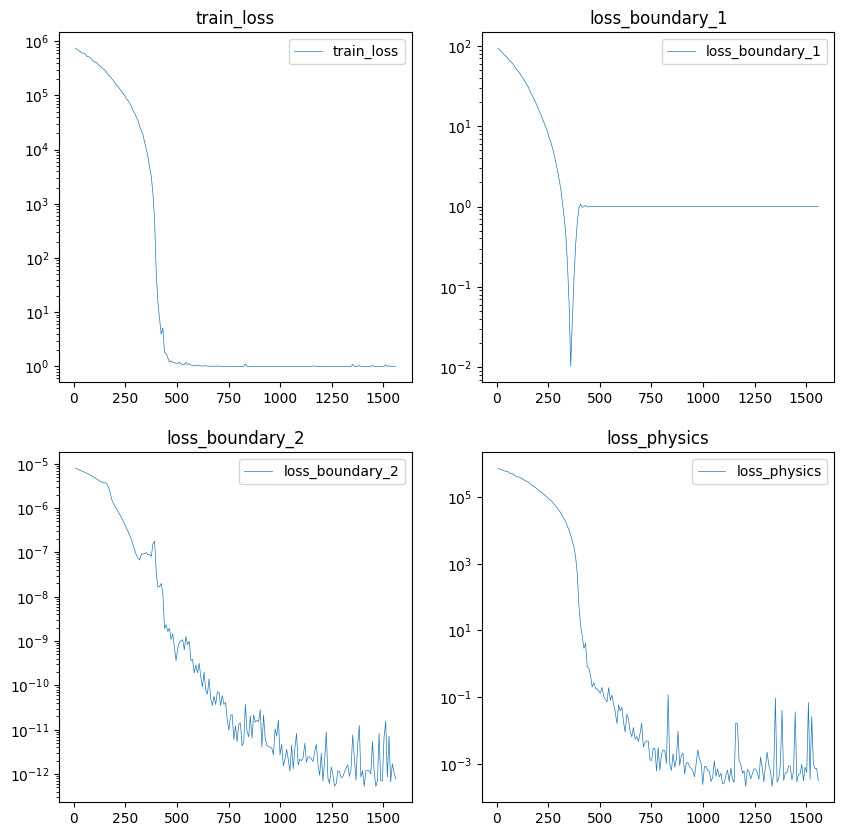

In [39]:
model = KANONet()

y_boundary = torch.zeros(BS, dtype=torch.float32, requires_grad=True)[:, None]

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = OneCycleLR(optimizer, max_lr=LR, total_steps=EPOCHS * len(train_dl))
step = -1
ldf = pd.DataFrame(columns=["train_loss", "valid_loss", "loss_boundary_1", "loss_boundary_2", "loss_physics", "epoch"])

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
out = display(fig, display_id=True)

for epoch in range(EPOCHS):
    # model.train()
    for pb, bcb, yb in train_dl:
        step += 1
        row = {}
        optimizer.zero_grad()

        y_boundary = torch.zeros(pb.shape[0], dtype=torch.float32, requires_grad=True)[:, None]

        # boundary
        uy_boundary = model(pb, bcb, y_boundary)
        loss_boundary_1 = criterion(uy_boundary, bcb)
        duy_boundary = torch.autograd.grad(
            uy_boundary, y_boundary, grad_outputs=torch.ones_like(uy_boundary), create_graph=True
        )[0]
        loss_boundary_2 = criterion(duy_boundary, torch.zeros_like(duy_boundary))

        # physics

        ## get the physical constants
        μ = get_μ(pb[:, 0])
        k = get_k(pb[:, 1])

        ## get the prediction and its derivatives
        uy = model(pb, bcb, yb)
        duy = torch.autograd.grad(uy, yb, grad_outputs=torch.ones_like(uy), create_graph=True)[0]
        duy2 = torch.autograd.grad(duy, yb, grad_outputs=torch.ones_like(duy), create_graph=True)[0]
        loss_physics = criterion(duy2 + μ[:, None] * duy + k[:, None] * uy, torch.zeros_like(duy2))

        loss_boundary_1 = loss_boundary_1
        loss_boundary_2 = loss_boundary_2 * 1e-4
        loss_physics = loss_physics * 1e-1

        loss = loss_boundary_1 + loss_boundary_2 + loss_physics
        loss.backward()
        optimizer.step()
        scheduler.step()
        row["train_loss"] = loss.item()
        row["loss_boundary_1"] = loss_boundary_1.item()
        row["loss_boundary_2"] = loss_boundary_2.item()
        row["loss_physics"] = loss_physics.item()
        row["epoch"] = epoch
        ldf.loc[step] = row

    pdf = ldf.groupby("epoch").tail(1)  # don't need to plot all the steps
    for i, (ax, col) in enumerate(
        zip(axes.flatten(), ["train_loss", "loss_boundary_1", "loss_boundary_2", "loss_physics"])
    ):
        ax.cla()
        plot_loss(pdf, columns=[col], ax=ax)
        ax.set_title(col)

    _ = out.update(fig)

plt.close(fig)  # Close the figure to prevent duplication

In [40]:
num_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {num_params}")

Number of parameters: 699


## Results

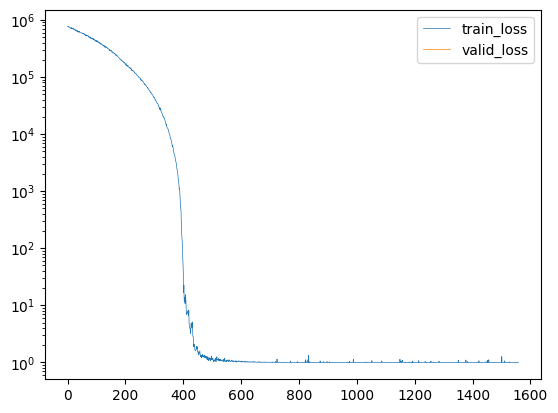

In [41]:
plot_loss(ldf)

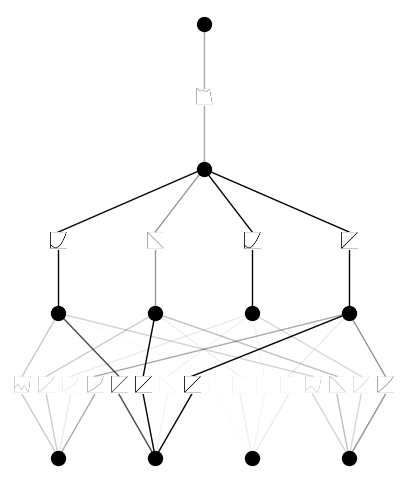

In [42]:
model.solution_network.plot()

/var/folders/5z/c8p82vrj5f333s_5w192fbw80000gn/T/ipykernel_17367/3354056115.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bcb = torch.tensor(bcb, dtype=torch.float32)


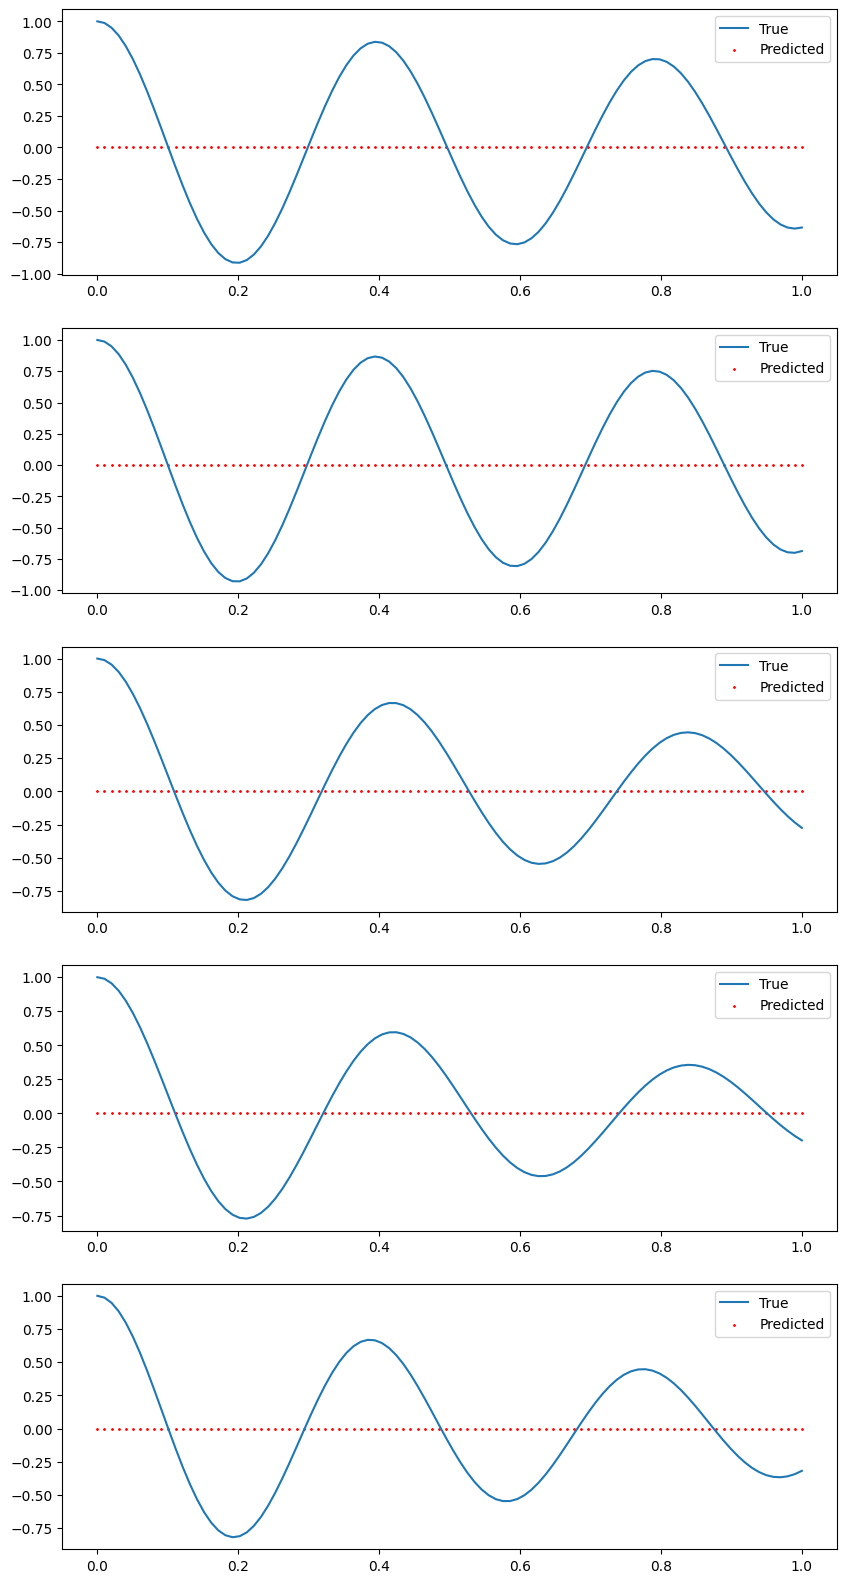

In [43]:
N = 100

uy_preds = []
uy_trues = []
for i in range(100):
    params, y, uy = valid_dset[i]
    d, w0 = params[0].item(), params[1].item()

    yb = np.linspace(0, 1, N)[..., None]
    uyb = f(d, w0, yb)
    bc = f(d, w0, 0.0)

    paramsb = params[None].repeat(100, 1)
    bcb = torch.tensor([bc], dtype=torch.float32)[:, None].repeat(100, 1)

    yb = torch.tensor(yb, dtype=torch.float32)
    uyb = torch.tensor(uyb, dtype=torch.float32)
    bcb = torch.tensor(bcb, dtype=torch.float32)

    with torch.inference_mode():
        uy_pred = model(paramsb, bcb, yb)

    uy_preds.append(uy_pred)
    uy_trues.append(uyb)

fig, axes = plt.subplots(5, 1, figsize=(10, 20))

for i, (uy_pred, uy_true) in enumerate(zip(uy_preds[:5], uy_trues[:5])):
    ax = axes[i]
    ax.plot(yb.flatten(), uy_true, label="True")
    ax.scatter(yb.flatten(), uy_pred, label="Predicted", color="r", s=1)
    ax.legend()

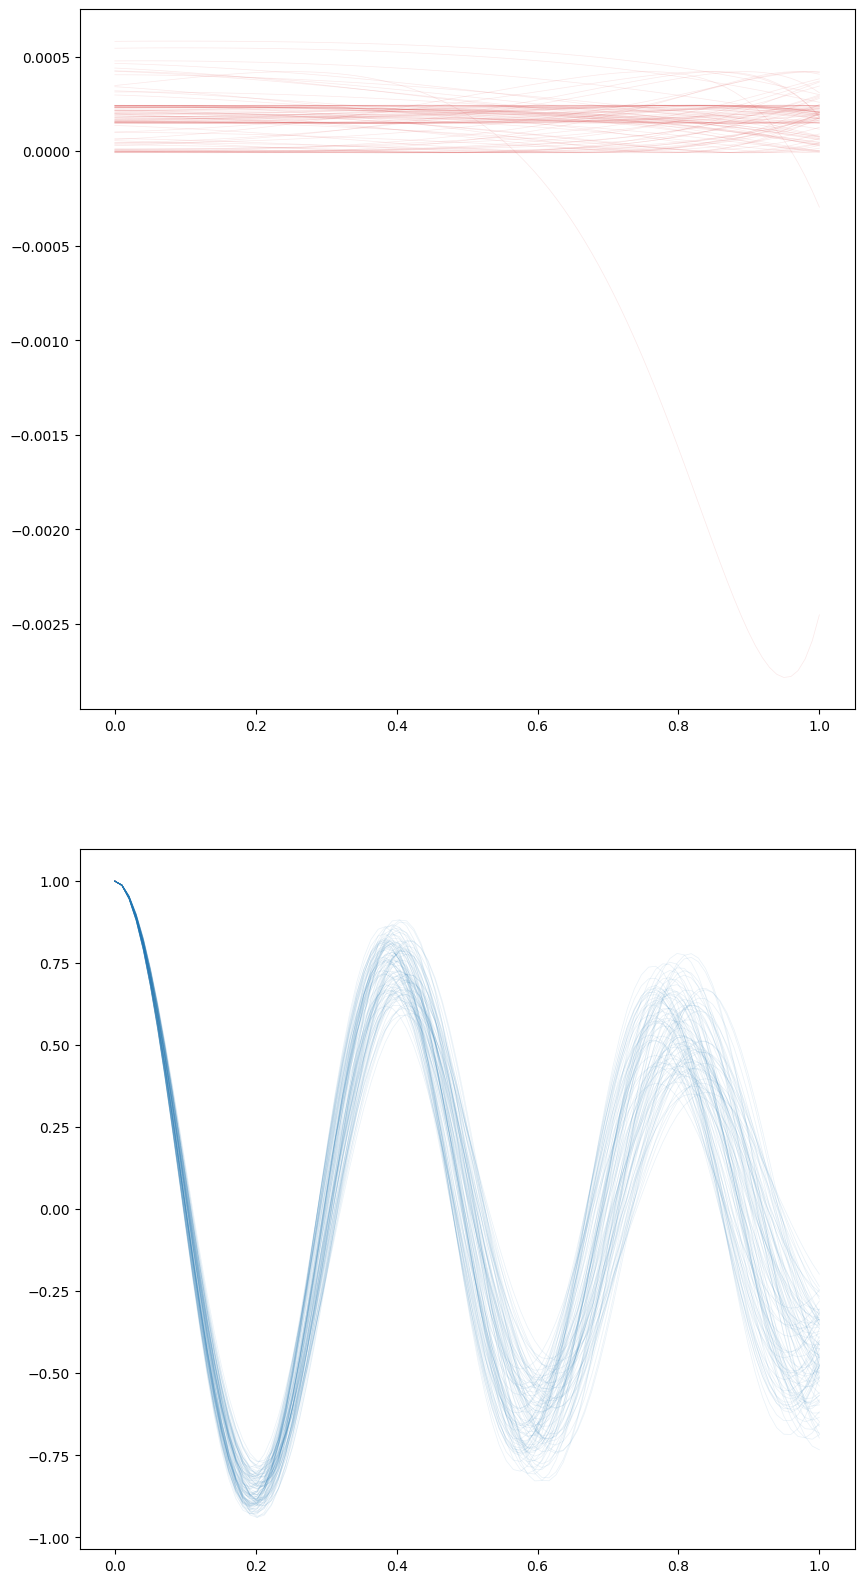

In [44]:
fig, axes = plt.subplots(2, 1, figsize=(10, 20))

ax = axes[0]
for uy_pred in uy_preds:
    axes[0].plot(yb.flatten(), uy_pred, color="tab:red", alpha=0.1, lw=0.5)

for uy_true in uy_trues:
    axes[1].plot(yb.flatten(), uy_true, color="tab:blue", alpha=0.1, lw=0.5)